#Zadanie 7 (7 pkt)
Celem zadania jest zaimplementowanie dwóch wersji naiwnego klasyfikatora Bayesa. 
* W pierwszej wersji należy dokonać dyskretyzacji danych - przedział wartości każdego atrybutu dzielimy na cztery równe przedziały i każdej ciągłej wartości atrybutu przypisujemy wartość dyskretną wynikająca z przynależności do danego przedziału.
* W drugiej wersji wartości likelihood wyliczamy z rozkładów normalnych o średnich i odchyleniach standardowych wynikających z wartości atrybutów.
Trening i test należy przeprowadzić dla zbioru Iris, tak jak w przypadku zadania z drzewem klasyfikacyjnym. Proszę przeprowadzić eksperymenty najpierw dla DOKŁADNIE takiego podziału zbioru testowego i treningowego jak umieszczony poniżej. W dalszej części należy przeprowadzić analizę działania klasyfikatorów dla różnych wartości parametrów. Proszę korzystać z przygotowanego szkieletu programu, oczywiście można go modyfikować według potrzeb. Wszelkie elementy szkieletu zostaną wyjaśnione na zajęciach.

* Dyskretyzacja danych - **0.5 pkt** 
* Implementacja funkcji rozkładu normalnego o zadanej średniej i odchyleniu standardowym. - **0.5 pkt**
* Implementacja naiwnego klasyfikatora Bayesa dla danych dyskretnych. - **2.0 pkt**
* Implementacja naiwnego klasyfikatora Bayesa dla danych ciągłych. - **2.5 pkt**
* Przeprowadzenie eksperymentów, wnioski i sposób ich prezentacji. - **1.5 pkt**

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import math
from collections import Counter
import numpy as np
from collections import defaultdict
from matplotlib import pyplot as plt

NR_CLASSES = 3
NR_FEATURES = 4


iris = load_iris()

In [3]:
class NaiveBayes:
    def __init__(self, full_data):
        self.priors = {}
        self.likelihoods = {}
        self.full_data = full_data

    def build_classifier(self, train_features, train_classes:np.array, feature_amount=NR_FEATURES, alpha=1):
        normalise = lambda v : v/len(train_classes)
        # setting priors
        for unique_class in set(train_classes):
            self.priors[unique_class] = Counter(train_classes)[unique_class]/len(train_classes)

        train_features = self.data_discretization(train_features)
        discr = self.data_discretization(self.full_data)
        # for every class
        for class_value in set(train_classes):
            matching = np.array([row for idx,row in enumerate(train_features) if train_classes[idx]==class_value])
            normalise =  lambda v : v/Counter(train_classes)[class_value]
            x = {}
            # for every column
            for i,col in enumerate(matching.T):
                # count how many times this feature appeared
                featureCounts = Counter(col)
                x[i] = {k: normalise(v) for k, v in featureCounts.items()}
                # used to get all the possible value for this feature
                actual_col = discr[:,i]
                # add zeros if feature didn't show up
                for bin in range(max(actual_col)+1):
                    if bin not in x[i].keys():
                        x[i][bin]=0

            self.likelihoods[class_value]=x 
        return self

    def data_discretization(self, data:np.ndarray, classes=3):
        discr_data = np.zeros(data.shape, dtype=int)
        for i in range(NR_FEATURES):
            col = data[:, i]
            full_col = self.full_data[:, i]
            chunks = np.array_split(np.sort(full_col), classes)
            new_col = np.zeros((len(col)))
            # discretization
            for j, val in enumerate(col):
                new_col[j] = self._find_section(val, chunks)
            discr_data[:, i] = new_col
        return discr_data

    def _find_section(self, val, chunks):
        """Finds index of chunk val belongs to"""
        for idx, chunk in enumerate(chunks):
                    if min(chunk) <= val <= max(chunk):
                        return idx

    def predict(self, sample):
        sample = self.data_discretization(np.reshape(sample, (1,NR_FEATURES)))
        sample = sample.reshape((NR_FEATURES))
        probability, feature_nr = 0,0
        most_probable_class, max_probability = (-1, -1)
        for cls in self.priors:
            #P(cechy|cls)=PI(cecha_i|cls)
            likelihood=self.priors[cls]
            for i,value in enumerate(sample):
                likelihood*=self.likelihoods[cls][i][value]
            if likelihood > max_probability:
                most_probable_class, max_probability = cls, likelihood
        return most_probable_class


class GaussianNaiveBayes:
    def __init__(self):
        self.priors = {}
        self.likelihoods = {}

    def build_classifier(self, train_features, train_classes):
        for unique_class in set(train_classes):
            self.priors[unique_class] = Counter(train_classes)[unique_class]/len(train_classes)
        self.nr_classes = max(train_classes) + 1
        self.means = np.array([train_features[np.where(train_classes==i)].mean(axis=0) for i in range(self.nr_classes)])
        self.stds = np.array([train_features[np.where(train_classes==i)].std(axis=0) for i in range(self.nr_classes)])

    @staticmethod
    def normal_dist(x, mean, std):
        return (1 / np.sqrt(2*np.pi*std**2)*np.exp(-0.5*((x-mean)/std)**2))

    def predict(self, sample):
        predictions = {}
        for cls in self.priors:
            likelihood = np.prod(self.normal_dist(sample,self.means[cls],self.stds[cls]))
            predictions[cls]=likelihood*self.priors[cls]
        return max(predictions, key=predictions.get) 


In [13]:
def run(i, randomise:bool):
    size = 0.1 * i
    x = iris.data
    y = iris.target
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=size, random_state=123) if not randomise else train_test_split(x, y, test_size=size)
    bayes = NaiveBayes(x)
    bayes.build_classifier(x_train, y_train)
    gauss = GaussianNaiveBayes()
    gauss.build_classifier(x_train, y_train)
    count, count_g = 0, 0
    for x,y in zip(x_test, y_test):
        val = bayes.predict(x)
        val_g = gauss.predict(x)
        if val == y: count+=1
        if val_g == y: count_g+=1
    return (count/len(y_test), count_g/len(y_test))

def plot(sizes:list, acc:list, title:str):
    plt.scatter(sizes, acc, marker='.')
    plt.xlabel("Test size")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.show()

0 0


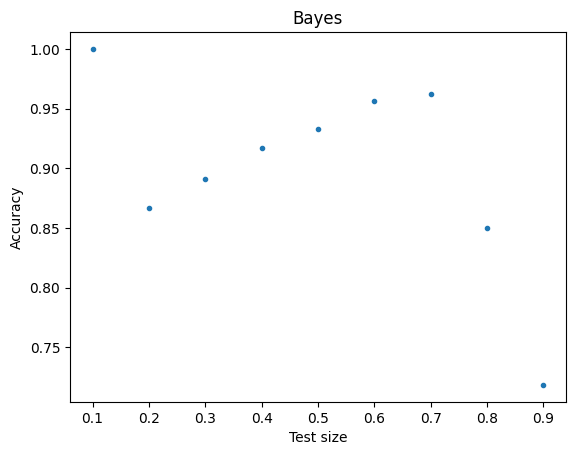

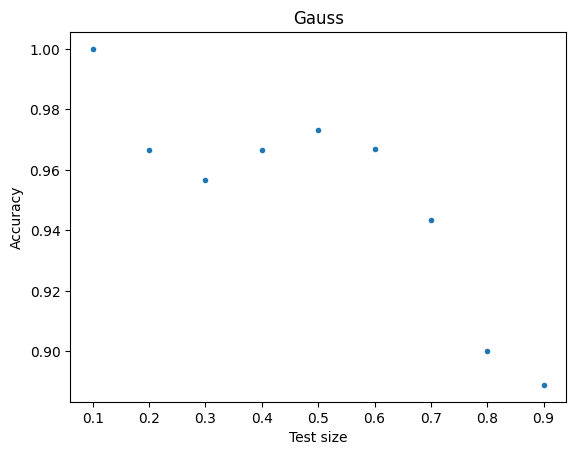

In [5]:
acc_bayes, acc_gauss = [], []
for i in range(1, 10):
    acc_b, acc_g = run(i, random=False)
    acc_bayes.append(acc_b)
    acc_gauss.append(acc_g)
print(np.argmax(acc_bayes), np.argmax(acc_gauss))
plot([x*0.1 for x in range(1,10)], acc_bayes, "Bayes")
plot([x*0.1 for x in range(1,10)], acc_gauss, "Gauss")

In [14]:
for i in range(1, 10):
    acc_bayes, acc_gauss = [], []
    for j in range(100):
        acc_b, acc_g = run(i, randomise=True)
        acc_bayes.append(acc_b)
        acc_gauss.append(acc_g)
    print(f'{i}. Bayes {sum(acc_bayes)/len(acc_bayes)}')
    print(f'{i}. Gauss {sum(acc_gauss)/len(acc_gauss)}')

1. Bayes 0.9299999999999998
1. Gauss 0.946
2. Bayes 0.9343333333333338
2. Gauss 0.9576666666666673
3. Bayes 0.9443478260869572
3. Gauss 0.9593478260869575
4. Bayes 0.931833333333334
4. Gauss 0.952500000000001
5. Bayes 0.9371999999999998
5. Gauss 0.952933333333333
6. Bayes 0.9340659340659339
6. Gauss 0.952307692307691
7. Bayes 0.9240566037735849
7. Gauss 0.9472641509433964
8. Bayes 0.894166666666667
8. Gauss 0.9415000000000003


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:83: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in true_divide
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in multiply


9. Bayes 0.7802962962962964
9. Gauss 0.7996296296296294


In [ ]:
b, g = np.zeros(50), np.zeros(50)
for _ in range(50):
    acc_bayes, acc_gauss = [], []
    for i in range(1, 10):
        acc_b, acc_g = run(i, randomise==True)
        acc_bayes.append(acc_b)
        acc_gauss.append(acc_g)
    b[np.argmax(acc_bayes)] += 1
    g[np.argmax(acc_gauss)] += 1
print(np.argmax(b), np.argmax(g))

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:83: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in multiply
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in true_divide
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice.
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\numpy\core

0 0


# Wnioski
- Nawet przy małych train_size GaussianNaiveBayes daje dobre wyniki, accuracy NaiveBayes przy małych train_size spada.
- Średnio Gauss daje lepsze wyniki od Bayes'a
- Obydwa modele dają najlepsze wyniki przy największym train_size
- Jest nazywany naiwny dlatego że nie rozróżnia kolejność. W tym problemie to nie wplywa, ale naprzykład 